In [1]:
#Imports
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import os
from scipy.interpolate import interp1d, CubicSpline
from tqdm import tqdm
import warnings


%matplotlib inline

In [2]:
dataset_dir = "C:\\Users\\nachi\\OneDrive\\Desktop\\Hawkins Lab\\datasets"
spec_data_path = os.path.join(dataset_dir,"hetvips_lamost_retry")
spec_data = Table.read(spec_data_path)
for name in sorted(spec_data.colnames):
    print(name)

ALPHA_FE
ALPHA_FE_ERR
AL_FE
AL_FE_ERR
AL_FE_FLAG
AL_FE_GRADCORR
BA_FE
BA_FE_ERR
BA_FE_FLAG
BA_FE_GRADCORR
CA_FE
CA_FE_ERR
CA_FE_FLAG
CA_FE_GRADCORR
CHI2
CHI2RATIO
CHI2RATIO_NA
CHI2_NA
CO_FE
CO_FE_ERR
CO_FE_FLAG
CO_FE_GRADCORR
CR_FE
CR_FE_ERR
CR_FE_FLAG
CR_FE_GRADCORR
CU_FE
CU_FE_ERR
CU_FE_FLAG
CU_FE_GRADCORR
C_FE
C_FE_ERR
C_FE_FLAG
C_FE_GRADCORR
DEC_1
Dec
FEH
FEH_ERR
FEH_FLAG
FEH_GRADCORR
FILENAME_2
FLAG_SINGLESTAR
LOGG
LOGG_ERR
LOGG_FLAG
LOGG_GRADCORR
MG_FE
MG_FE_ERR
MG_FE_FLAG
MG_FE_GRADCORR
MN_FE
MN_FE_ERR
MN_FE_FLAG
MN_FE_GRADCORR
NA_FE
NA_FE_ERR
NA_FE_FLAG
NA_FE_GRADCORR
NI_FE
NI_FE_ERR
NI_FE_FLAG
NI_FE_GRADCORR
N_FE
N_FE_ERR
N_FE_FLAG
N_FE_GRADCORR
O_FE
O_FE_ERR
O_FE_FLAG
O_FE_GRADCORR
ObjID_2
QFLAG_CHI2
QFLAG_CHI2NA
RA
RA_1
RV_1
RV_2
RV_ERR
SI_FE
SI_FE_ERR
SI_FE_FLAG
SI_FE_GRADCORR
SNR_DPARALLAX
SNR_G
SNR_I
SNR_R
SNR_U
SNR_Z
SPECID_1
STARID
SUBCLASS
Separation
Separation_2
TEFF
TEFF_ERR
TEFF_FLAG
TEFF_GRADCORR
TI_FE
TI_FE_ERR
TI_FE_FLAG
TI_FE_GRADCORR
UQFLAG
VMIC
VMIC_ERR
VMIC_F

In [7]:
spec_quality_mask = np.where((spec_data["FEH_ERR"] < 0.2) & (spec_data["classification"] == "STAR") & (spec_data["TEFF"] > 0) & ( 1 <= spec_data["LOGG"] ) & (spec_data["LOGG"] <= 5) & (spec_data["TEFF"] <= 25000) & (spec_data["SNR_G"] > 5) & (abs(spec_data["RV_2"]) < 600) & (spec_data["RV_ERR"] < 10) & (spec_data["bp_rp"] >= 1.0) & (spec_data["bp_rp"] <= 1.5))
quality_spec = spec_data[spec_quality_mask]
len(quality_spec)

558

In [8]:
unique, counts = np.unique(quality_spec["stellartype"], return_counts=True)
d = dict(zip(unique, counts))
d

{'A': 11, 'C': 8, 'F': 4, 'G': 158, 'K': 372, 'M': 4, 'W': 1}

Text(0, 0.5, 'counts')

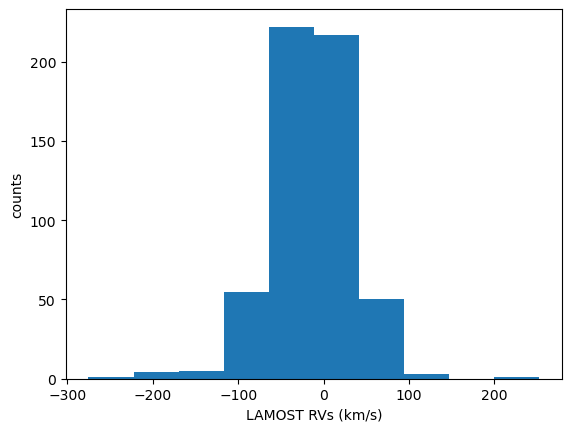

In [9]:
plt.hist(quality_spec["RV_2"])
plt.xlabel("LAMOST RVs (km/s)")
plt.ylabel("counts")

Text(0, 0.5, 'counts')

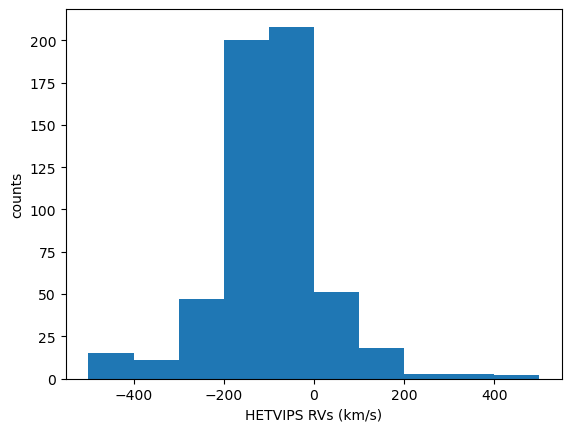

In [10]:
plt.hist(quality_spec["RV_1"])
plt.xlabel("HETVIPS RVs (km/s)")
plt.ylabel("counts")

In [11]:
np.savetxt("barycor_new.txt",quality_spec["barycor"]/1000)

In [12]:
np.savetxt("rvs2_new.txt",quality_spec["RV_2"])

In [13]:
np.savetxt("SNRs_new.txt",quality_spec["sn"])

In [14]:
cut_data = []
cut_var = []
for i in range(len(quality_spec["spec"])):
    cut_data.append(quality_spec["spec"][i][50:-50])
    cut_var.append(quality_spec["spec_error"][i][50:-50])

cut_data = np.array(cut_data)

cut_var = np.array(cut_var)

In [15]:
counter = 0
nan_flag = []
for obj in cut_var:
    if True in np.isnan(obj):
        counter += 1
        nan_flag.append(True)
    else:
        nan_flag.append(False)
counter

226

In [16]:
new_nan_flag = []
counter = 0 
for obj in cut_data:
    if True in np.isnan(obj[:50]):
        counter += 1
        new_nan_flag.append(True)
    else:
        new_nan_flag.append(False)
counter

109

In [17]:
np.nanmedian(cut_var.flatten())

0.6290936850338122

In [18]:
#Sampling the spectra
import time
sampling_timings = [] #Stores the time taken to perform each BMC operation (just to check effeciency for fun)
sampled_spectras = [] #Stores the up, down or evenly sampled spectra
new_var = []
corrected = []

def sample_data(current_spectra_flux, var, sampling_timings=[], sampled_spectras=[]): #new_sample_size is the size you set to up, down or evenly sample

    start = time.perf_counter()

    with warnings.catch_warnings():
        warnings.filterwarnings("error")
        try:
            median_var = np.nanmedian(var)
        except:
            median_var = 0.6


    current_spectra_flux = np.array(current_spectra_flux)
    nan_mask = np.isnan(current_spectra_flux) #array of True False values of where the nan values are True 
    nan_indices = np.flatnonzero(nan_mask) #gets indecies of all non zero elements (here all True elements in the mask) i.e all data that is nan
    non_nan_indices = np.flatnonzero(~nan_mask) #the ~ reverses the True False values. We now have indecies of all the data that is not nan
    current_spectra_flux[nan_indices] = np.interp(nan_indices,non_nan_indices,current_spectra_flux[non_nan_indices]) # NaN values removed

    var[nan_indices] = median_var * 3

    var_nan_mask = np.isnan(var)
    var_nan_indices = np.flatnonzero(var_nan_mask)
    var[var_nan_indices] = median_var * 3
    
    finish = time.perf_counter()
    
    new_var.append(var)
    sampling_timings.append(finish-start)
    sampled_spectras.append(current_spectra_flux)

for i,spec in enumerate(cut_data):
    sample_data(spec,cut_var[i],sampling_timings,sampled_spectras)

In [19]:
counter = 0
for obj in cut_var:
    if True in np.isnan(obj):
        counter += 1
counter

0

In [10]:
#New BMC
normalized_spectra = [] #Stores the normalized spectra
continuums = [] #Stores the continuums of the spectra

def BMC(resampled_flux,window_size=50,percentile=98,normalized_spectra=[],continuums=[]):

    spec_len = len(resampled_flux) 
    half_window_size = window_size//2 #We do this because the window is centered around the current value being determined. i.e index 100 will consider indecies 51-150 as part of the window
    
    continuum = []
    
    for i in range(half_window_size, spec_len-half_window_size):
        continuum_val = np.percentile(resampled_flux[i-half_window_size:i+half_window_size+1],percentile)
        continuum.append(continuum_val)

    continuum = ([continuum[0]] * half_window_size) + continuum
    continuum += [continuum[-1]] * half_window_size  #Window remains stationary for the last half_window_size values so we append the same value
    
    continuum = np.array(continuum)
    normalized = resampled_flux/continuum

    normalized_spectra.append(normalized)
    continuums.append(continuum)

for resampled_flux in tqdm(sampled_spectras):
    BMC(resampled_flux,50,97,normalized_spectra,continuums)

100%|██████████| 1391/1391 [02:18<00:00, 10.04it/s]


In [21]:
lambs = np.linspace(3570,5440,936)
from scipy import stats

normalized_spectra = [] #Stores the normalized spectra
cntm_spectra = []

def BMCcntflux(lams, fluxes,width = 100,ptile=98):
	continuumflux = []
	lampts = []
	for i in np.arange(len(fluxes)):
		testind = np.where((lams >= lams[i]-(width/2.0)) & (lams <= lams[i]+(width/2.0)))[0]
		lampts.append( (lams[i]-(width/2.0) +lams[i]+(width/2.0) )/2.0 )
		continuumflux.append(stats.scoreatpercentile(fluxes[testind],ptile))
	norm_spec = fluxes/continuumflux
	return norm_spec,continuumflux

for resampled_flux in tqdm(sampled_spectras):
	norm_values, cntm_values = (BMCcntflux(lambs,resampled_flux,50,98))
	normalized_spectra.append(norm_values)
	cntm_spectra.append(cntm_values)

100%|██████████| 558/558 [00:06<00:00, 89.35it/s]


In [12]:
lambs = np.linspace(3570,5440,936)
from scipy import stats

normalized_spectra = [] #Stores the normalized spectra

def BMCcntflux(lams, fluxes,width = 100,ptile=98):
	continuumflux = []
	lampts = []
	for i in np.arange(len(fluxes)):
		testind = np.where((lams >= lams[i]-(width/2.0)) & (lams <= lams[i]+(width/2.0)))[0]
		lampts.append( (lams[i]-(width/2.0) +lams[i]+(width/2.0) )/2.0 )
		continuumflux.append(stats.scoreatpercentile(fluxes[testind],ptile))
	norm_spec = fluxes/continuumflux

	try:
			Z  = np.polyfit(lampts, continuumflux,deg=3)
	except TypeError:
		print ('WARNING couldnt fit conitnuum returning nans')
		return np.array([np.nan]*len(lams))
	func = np.poly1d(Z)
	continuumflux = func(lams)
	fluxes /= continuumflux
	return fluxes

for resampled_flux in tqdm(sampled_spectras):
    normalized_spectra.append(BMCcntflux(lambs,resampled_flux,100,98))

100%|██████████| 1391/1391 [00:18<00:00, 75.75it/s]


In [ ]:
""""""
#Plotting graphs
idx = 1000 #change this to the idx of the spectra you want to see
continuum = continuums[idx]
normalized = normalized_spectra[idx]
resampled_flux = sampled_spectras[idx]

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(16, 10),sharex=True)

ax1.plot(np.linspace(3470,5540,1036),quality_spec["spec"][idx])
ax1.set_ylim(top=max(resampled_flux)+5)
ax1.set_title("raw spectra")

ax2.plot(np.linspace(3570,5440,len(resampled_flux)),resampled_flux)
ax2.set_ylim(top=max(resampled_flux)+5)
ax2.set_title("Interpolated (No NaN Values)")

ax3.plot(np.linspace(3570,5440,len(resampled_flux)),resampled_flux)
ax3.plot(np.linspace(3570,5440,len(continuum)),continuum)
ax3.set_ylim(top=max(resampled_flux)+5)
ax3.set_title("spectra with continuum")

ax4.plot(np.linspace(3570,5440,len(normalized)),normalized)
ax4.set_ylim(top=max(normalized)+0.1)
ax4.set_title("normalized spectra")
fig.text(0.5, 0.04, 'Wavelengths', ha='center',size=15)
fig.text(0.09, 0.5, 'Flux', va='center', rotation='vertical',size=15)
plt.show()


In [22]:
#Appending the new data to the old fits file data
quality_spec.add_column(normalized_spectra,name="spec_norm")
quality_spec.add_column(cntm_spectra,name="spec_continuums")
quality_spec.add_column(sampled_spectras,name="spec_sampled")
quality_spec.add_column(new_var,name="updated_var")
quality_spec.add_column(nan_flag,name="nan_flag")
quality_spec.add_column(new_nan_flag,name="new_nan_flag")

In [23]:
#Saving the modified file
from astropy.io import fits
modified_data_path = os.path.join(dataset_dir,"retry_updated.fits")
hdu = fits.BinTableHDU(quality_spec)
hdu.writeto(modified_data_path,overwrite=True)

In [ ]:
dataset_dir = "C:\\Users\\nachi\\OneDrive\\Desktop\\Hawkins Lab\\datasets"
spec_data_path = os.path.join(dataset_dir,"retry_updated.fits")
spec_data = Table.read(spec_data_path)
for name in sorted(spec_data.colnames):
    print(name)